# Summary

1. **Quantum Jump Method**

2. **Two level atom:**
- Initial state $\ket{\psi(0)}=\ket{g}$
    - [Figure 0](#Figure0) : excitation density for two trajectories
    - [Figure 1](#Figure1) : $n_{e}(t)$ - numerical result
    - [Figure 2](#Figure2) : $n_{e}(t)$ - exact result
    - [Figure 3](#Figure3) : $n_{e}(t)$ - numerics vs. exact
      

4. **Interacting atoms:**
- Initial state $\ket{\psi(0)}=\ket{g}\otimes\ket{g}$   
    - [Figure 4-1](#Figure4-1) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerical result 
    - [Figure 4-2](#Figure4-2) : $n_{e,1}(t)$, $n_{e,2}(t)$ - exact result 
    - [Figure 4-3](#Figure4-3) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerics vs. exact

$\newline$  
- Initial state $\ket{\psi(0)}=\ket{g}\otimes\ket{e}$
    - [Figure 4-4](#Figure4-4) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerical result
    - [Figure 4-5](#Figure4-5) : $n_{e,1}(t)$, $n_{e,2}(t)$ - exact result  
    - [Figure 4-6](#Figure4-6) : $n_{e,1}(t)$ - numerics vs. exact 
    - [Figure 4-7](#Figure4-7) : $n_{e,2}(t)$ - numerics vs. exact

$\newline$  
- Initial state $\ket{\psi(0)}=\frac{1}{2}[0,1,-1,0]$
    - [Discussion 4-8](#Discussion)
    - [Figure 4-9](#Figure4-9) : Compare the dynamics of two initial states 


# 1. Quantum Jump method to solve master equation
# Lindblad master equation

$\partial_{t}\rho = -i[H,\rho] +  \gamma(L\rho L^{\dagger}-\frac{1}{2}\{L^{\dagger}L,\rho \})= -i(H_{eff}\rho - \rho H^{\dagger}_{eff})+\gamma L\rho L^{\dagger}$

$H_{eff}= H - \frac{i}{2}\gamma L^{\dagger}L$

# Integrate the wavefunction
At each time step, stochastically choose

$\ket{\psi(t+\delta t)} \propto e^{-iH_{eff}\delta t}\ket{\psi(t)} = (I - i H_{eff}\delta t - \frac{1}{2}H_{eff}(\delta t)^{2}+ ...)\ket{\psi(t)}$

$\ket{\psi(t+\delta t)} \propto L\psi(t)$


# In our cases 

Two-level atom

$H = \Omega\sigma^x$

$L = \sigma^-$

$L^\dagger = \sigma^+$

Interacting atoms 

$H = \Omega(\sigma^x_1+\sigma^x_2)$

$L = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

$L^{\dagger} = \frac{1}{\sqrt{2}}\sigma^{+}_{1}+\frac{1}{\sqrt{2}}\sigma^{+}_{2}$



# 2. Two level atom

In [43]:
# Define two-level sysyem
omega = 15
gamma = omega / 3
H = omega * S_x(1,1)
L = S_minus(1,1)
total_time = 1.6
dt = 0.000016

twoLevelSystem = QuantumSystem(H, gamma, L, dt)


Choose initial state $\ket{\psi(0)}= \ket{g}=
\begin{pmatrix}
    1 \\
    0 \\
\end{pmatrix}$

In [44]:
states_twoLevelSystem, ne_twoLevelSystem, ne_avg_twoLevelSystem,  time_values_twoLevelSystem = N_trajectory_twoLevelSystem(3000, phi_basis_vecs(1)[0], total_time, dt, 0.005, twoLevelSystem)


100%|█████████████████████████████████████| 3000/3000 [1:18:16<00:00,  1.57s/it]


Simulation complete


<a id="Figure0"></a>

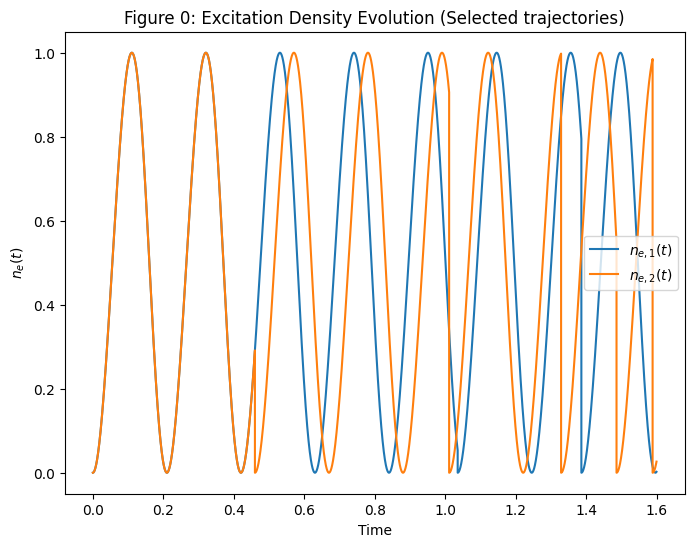

In [81]:
traj_ne_twoLevelSystem = [ne_twoLevelSystem[0],ne_twoLevelSystem[3]]
plot_excitation_density(time_values_twoLevelSystem, traj_ne_twoLevelSystem, 'Figure 0: Excitation Density Evolution (Selected trajectories)', 0)


<a id="Figure0"></a>

<a id="Figure1"></a>

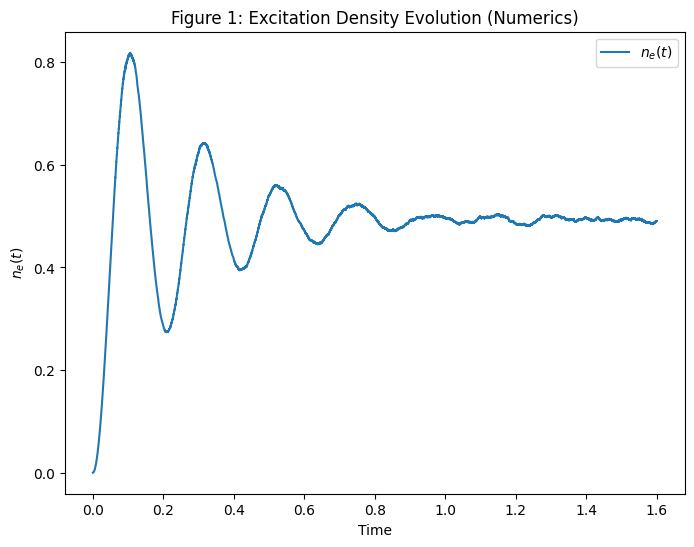

In [45]:
plot_excitation_density(time_values_twoLevelSystem, ne_avg_twoLevelSystem, 'Figure 1: Excitation Density Evolution (Numerics)', 0)



<a id="Figure0"></a>

Next, calculate the exact $n_{e}(t)$

In [46]:
ne_exact_twoLevelSystem, ne_infty_twoLevelSystem = exact_twoLevelSystem(15, 5, phi_basis_vecs(1)[0], time_values_twoLevelSystem)



<a id="Figure2"></a>

Plot the exact $n_e(t)$

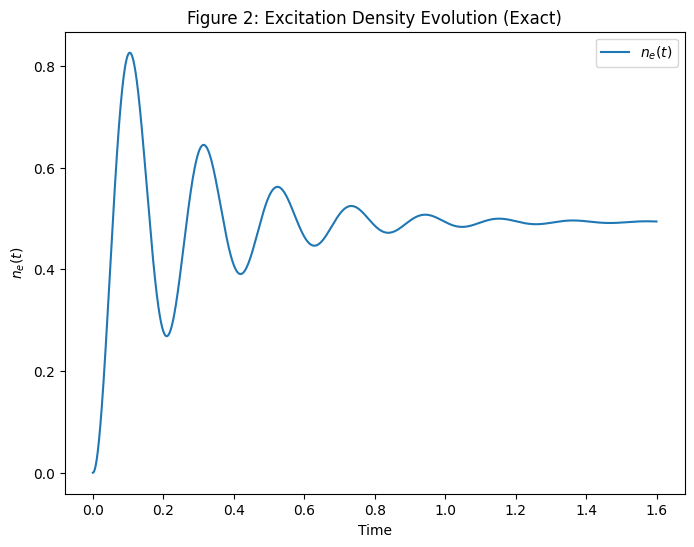

In [60]:
plot_excitation_density(time_values_twoLevelSystem, ne_exact_twoLevelSystem, 'Figure 2: Excitation Density Evolution (Exact)', 0)



<a id="Figure3"></a>

Next, put $n_{e}(t)$ of numerical and exact results together:

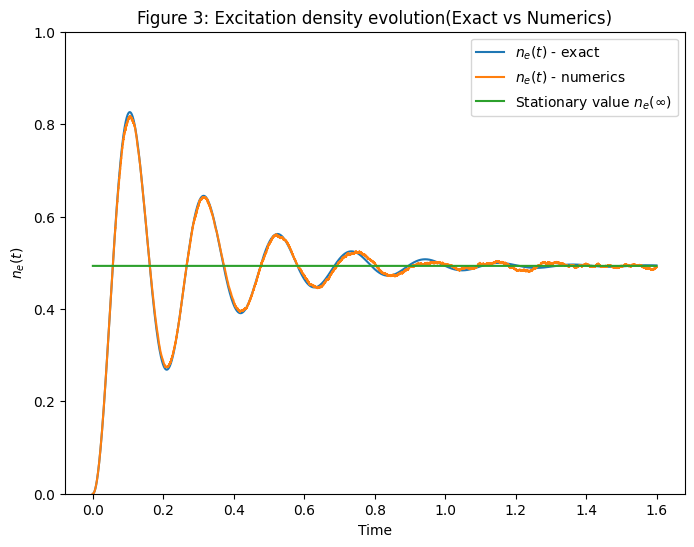

In [48]:
ne_comparison = [ne_exact_twoLevelSystem, ne_avg_twoLevelSystem, ne_infty_twoLevelSystem]
plot_excitation_density(time_values_twoLevelSystem, ne_comparison, 'Figure 3: Excitation density evolution(Exact vs Numerics)', 1)



# 3. Interacting atoms

In [11]:
# Define interacting atom system
omega = 15
gamma = 2*omega/3
H = omega * (S_x(2,1) + S_x(2,2))
L = (S_minus(2,1) + S_minus(2,2)) / np.sqrt(2)
total_time = 1.6
dt = 0.000016

twoAtomSystem = QuantumSystem(H, gamma, L, dt)

Try initial state $\ket{\psi(0)}= \ket{gg}=
\begin{pmatrix}
    1 \\
    0 \\
    0 \\
    0 \\
\end{pmatrix}$

In [63]:
states_twoAtomSystem_0, ne_twoAtomSystem_0, ne_avg_twoAtomSystem_0, time_values_twoAtomSystem_0 = N_trajectory_twoAtomSystem(2700, phi_basis_vecs(2)[0], total_time, dt, 0.005, twoAtomSystem)


100%|█████████████████████████████████████| 2700/2700 [2:58:24<00:00,  3.96s/it]


Simulation complete


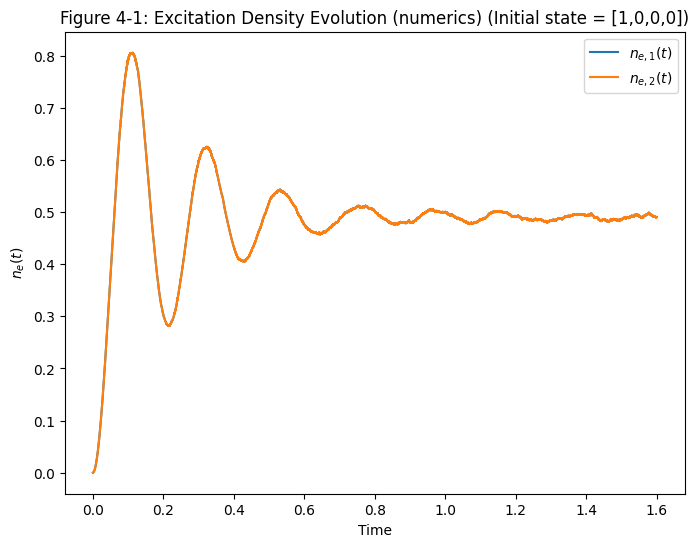

In [82]:
plot_excitation_density(time_values_twoAtomSystem_0, ne_avg_twoAtomSystem_0, 'Figure 4-1: Excitation Density Evolution (numerics) (Initial state = [1,0,0,0])', 0)



Next, calculate the exact $n_{e,k}(t)$

In [67]:
ne_exact_twoAtomSystem_0, ne_infty_twoAtomSystem_0 = exact_twoAtomSystem(omega, gamma, phi_basis_vecs(2)[0], time_values_twoAtomSystem_0)


<a id="Figure4-2"></a>

Plot the exact $n_{e,k}(t)$

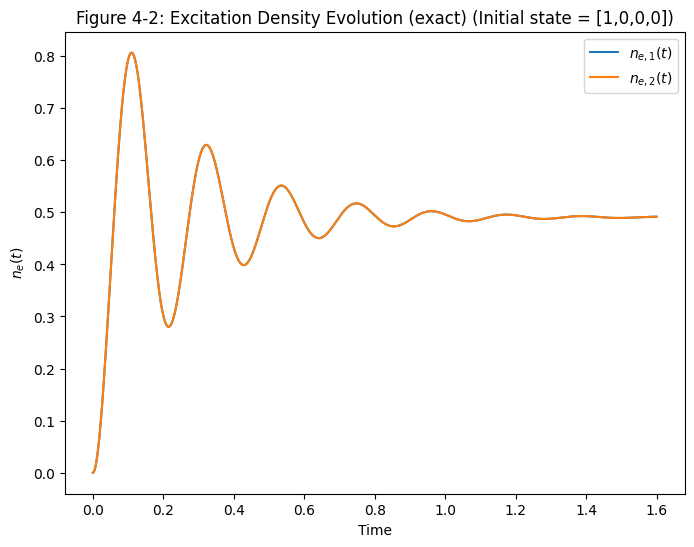

In [83]:
plot_excitation_density(time_values_twoAtomSystem_0, ne_exact_twoAtomSystem_0, 'Figure 4-2: Excitation Density Evolution (exact) (Initial state = [1,0,0,0])', 0)



Next, put $n_{e,k}(t)$ of numerical and exact results together:

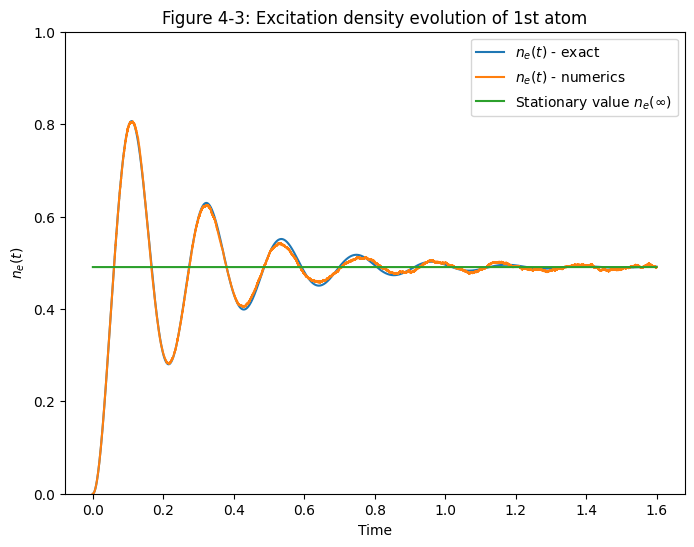

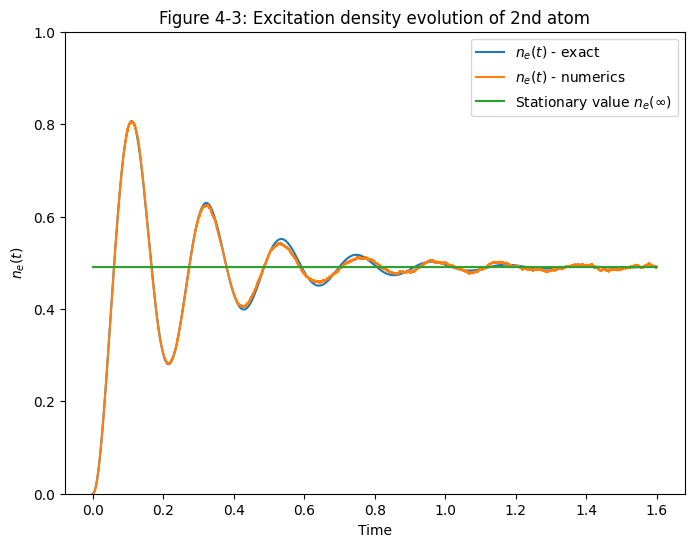

In [69]:
ne1_comparison_0 = [ne_exact_twoAtomSystem_0[0], ne_avg_twoAtomSystem_0[0], ne_infty_twoAtomSystem_0[0]]
ne2_comparison_0 = [ne_exact_twoAtomSystem_0[1], ne_avg_twoAtomSystem_0[1], ne_infty_twoAtomSystem_0[1]]
plot_excitation_density(time_values_twoAtomSystem_0, ne1_comparison_0, 'Figure 4-3: Excitation density evolution of 1st atom', 1)
plot_excitation_density(time_values_twoAtomSystem_0, ne2_comparison_0, 'Figure 4-3: Excitation density evolution of 2nd atom', 1)

<a id="Figure4-3"></a>

Next, try initial state $\ket{\psi(0)}= \ket{ge} = 
\begin{pmatrix}
    0 \\
    1 \\
    0 \\
    0 \\
\end{pmatrix}$

In [37]:
states_twoAtomSystem_1, ne_twoAtomSystem_1, ne_avg_twoAtomSystem_1, time_values_twoAtomSystem_1 = N_trajectory_twoAtomSystem(2700, phi_basis_vecs(2)[1], total_time, dt, 0.005, twoAtomSystem)


100%|█████████████████████████████████████| 2700/2700 [1:46:38<00:00,  2.37s/it]


Simulation complete


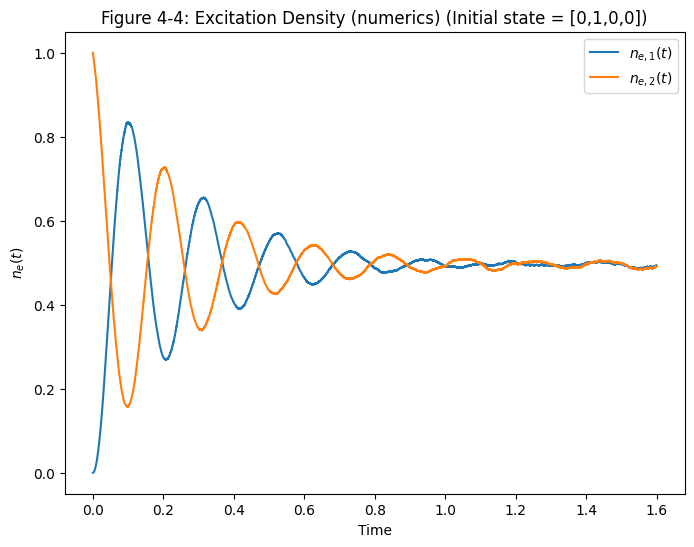

In [78]:
plot_excitation_density(time_values_twoAtomSystem_1, ne_avg_twoAtomSystem_1, 'Figure 4-4: Excitation Density (numerics) (Initial state = [0,1,0,0])', 0)



<a id="Figure4"></a>

<a id="Figure4-4"></a>

Next, calculate the exact $n_{e,k}(t)$

In [38]:
ne_exact_twoAtomSystem_1, ne_infty_twoAtomSystem_1 = exact_twoAtomSystem(omega, gamma, phi_basis_vecs(2)[1], time_values_twoAtomSystem_1)



<a id="Figure4-5"></a>

Plot the exact $n_{e,k}(t)$

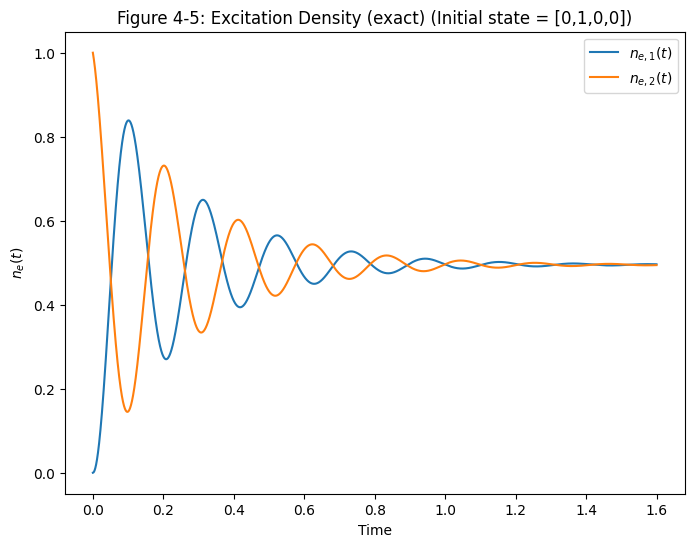

In [79]:
plot_excitation_density(time_values_twoAtomSystem_1, ne_exact_twoAtomSystem_1, 'Figure 4-5: Excitation Density (exact) (Initial state = [0,1,0,0])', 0)



<a id="Figure4-6"></a>

Next, put $n_{e,k}(t)$ of numerical and exact results together:

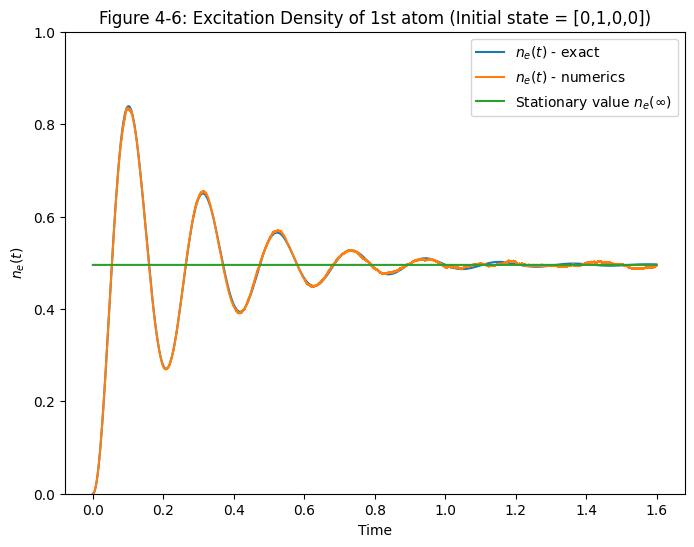

In [71]:
ne1_comparison_1 = [ne_exact_twoAtomSystem_1[0], ne_avg_twoAtomSystem_1[0], ne_infty_twoAtomSystem_1[0]]
ne2_comparison_1 = [ne_exact_twoAtomSystem_1[1], ne_avg_twoAtomSystem_1[1], ne_infty_twoAtomSystem_1[1]]
plot_excitation_density(time_values_twoAtomSystem_1, ne1_comparison_1, 'Figure 4-6: Excitation Density of 1st atom (Initial state = [0,1,0,0])', 1)


<a id="Figure4-7"></a>

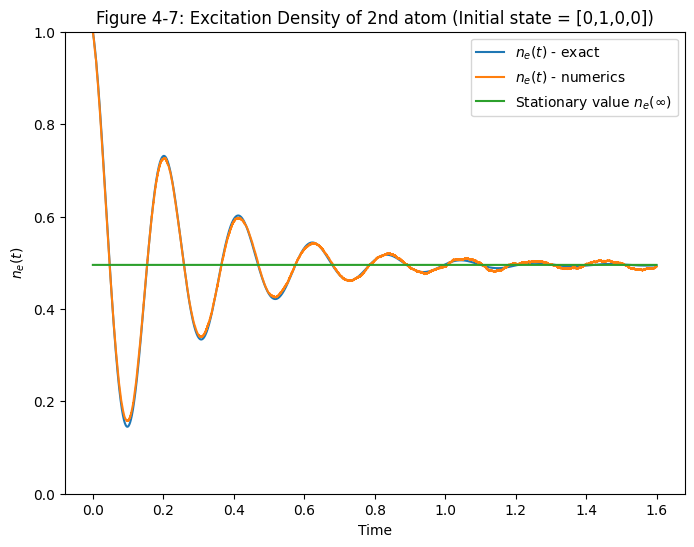

In [72]:
plot_excitation_density(time_values_twoAtomSystem_1, ne2_comparison_1, 'Figure 4-7: Excitation Density of 2nd atom (Initial state = [0,1,0,0])', 1)



Next, try initial state $\ket{\psi(0)} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
    0 \\
    1 \\
    -1 \\
    0 \\
\end{pmatrix}$ (Dark state)

it can be easily checked that the propagation operator keeps the dark state unchanged

In [13]:
# propagation on the dark state
dark_state = np.array([[0],[np.sqrt(1/2)],[-np.sqrt(1/2)],[0]], dtype = complex)
print(twoAtomSystem.U_eff @ dark_state == dark_state)
    

[[ True]
 [ True]
 [ True]
 [ True]]


and the jump operator destroy the dark state

In [14]:
print(twoAtomSystem.L @ dark_state)

[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


<a id="Discussion"></a>

Thus, if the chosen initial state is dark state, it will remain the same state as time evolves.
On the other hand, for general initial states, their dark component will be destroyed as time evolves due to jumps.

Compare the dynamics given initial state $\ket{\psi(0)} =
\begin{pmatrix}
    \frac{1}{2} \\
    \frac{1}{2} \\
    -\frac{1}{2} \\
    \frac{1}{2} \\
\end{pmatrix}$
vs initial state $\ket{\psi(0)} =
\begin{pmatrix}
    \sqrt{\frac{1}{2}} \\
    0 \\
    0 \\
    \sqrt{\frac{1}{2}} \\
\end{pmatrix}$

In [12]:
init_state = np.array([[1/2], [1/2], [-1/2], [1/2]], dtype=complex) 
states_twoAtomSystem_2, ne_twoAtomSystem_2, ne_avg_twoAtomSystem_2, time_values_twoAtomSystem_2 = N_trajectory_twoAtomSystem(3000, init_state, total_time, dt, 0.005, twoAtomSystem)



100%|█████████████████████████████████████| 3000/3000 [1:57:57<00:00,  2.36s/it]


Simulation complete


In [14]:
init_state_3 = np.array([[np.sqrt(1/2)], [0], [0], [np.sqrt(1/2)]], dtype=complex) 
states_twoAtomSystem_3, ne_twoAtomSystem_3, ne_avg_twoAtomSystem_3, time_values_twoAtomSystem_3 = N_trajectory_twoAtomSystem(3000, init_state, total_time, dt, 0.005, twoAtomSystem)



100%|█████████████████████████████████████| 3000/3000 [2:14:56<00:00,  2.70s/it]


Simulation complete


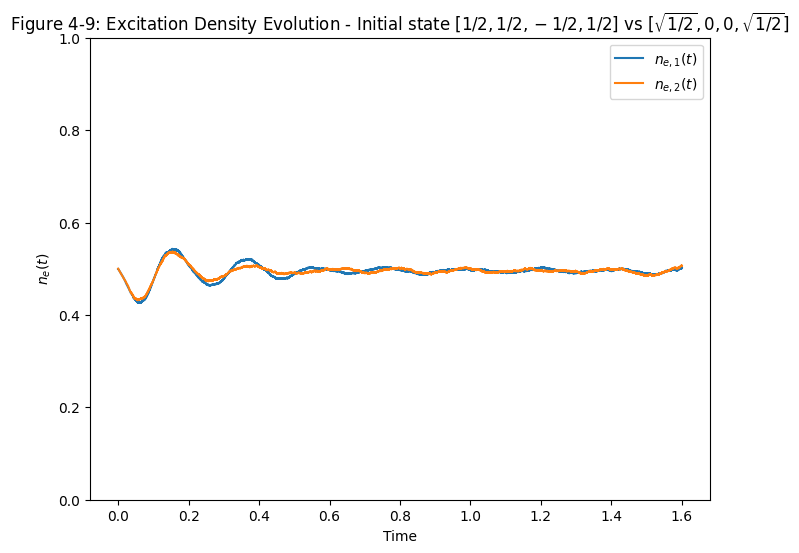

In [28]:
comparison_3 = [ne_avg_twoAtomSystem_2[1],ne_avg_twoAtomSystem_3[0]]

plot_excitation_density(time_values_twoAtomSystem_3, comparison_3, r'Figure 4-9: Excitation Density Evolution - Initial state $[1/2,1/2,-1/2,1/2]$ vs $[\sqrt{1/2},0,0,\sqrt{1/2}]$', 0)




<a id="Figure4-9"></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.optimize import fsolve
from sympy import Matrix
from tqdm import tqdm
import time

In [3]:
# For N = 1 , {|g), |e)}
# For N = 2 , {|g)|g), |g)|e), |e)|g), |e)|e)}
def phi_basis_vecs(N):
    phi = np.array([[0+0j]*(2**N)]).transpose()
    base = []
    for i in range(2**N):
        phi[i] += 1
        base.append(phi)
        phi = np.array([[0+0j]*(2**N)]).transpose()
    return base

# For N = 1 , {GG=|g)(g|, GE=|g)(e|, EG=|e)(g|, EE=|e)(e|}
# For N = 2 , {GGGG,GGGE,GGEG,GGEE,GEGG,GEGE,GEEG,GEEE,EGGG,EGGE,EGEG,EGEE,EEGG,EEGE,EEEG,EEEE}
def rho_basis_ops(N):
    zero = np.zeros((2,2), dtype = complex)
    rho = np.zeros((2,2), dtype = complex)
    base = []
    for i in range(N-1):
        rho = np.kron(rho, zero)
    for i in range(2**N):
        for j in range(2**N):
            rho[i][j] = 1
            base.append(rho)
            rho= np.zeros((rho.shape), dtype = complex)
    return base

def id(N):
    matrix = np.array([[1, 0],[0, 1]], dtype = complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    for i in range(N-1):
        matrix = np.kron(matrix,identity)
    return matrix

def S_x(N, n):
    s_x = np.array([[0, 1], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_x)
    return matrix

def S_plus(N, n):
    s_plus =  np.array([[0, 0], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_plus)
    return matrix

def S_minus(N, n):
    s_minus = np.array([[0, 1], [0, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_minus)
    return matrix

In [4]:
def dagger(matrix):
    return np.transpose(np.conj(matrix))

def commutator(matrix_1, matrix_2, sign):
    if sign == 0:
        return matrix_1 @ matrix_2 - matrix_2 @ matrix_1
    else:
        return matrix_1 @ matrix_2 + matrix_2 @ matrix_1

def jump_probability(state):
    dp = 1- np.linalg.norm(state)
    return dp

In [20]:
def plot_excitation_density(time, n_e, title_text, compare):
    plt.figure(figsize=(8,6))
    
    if len(n_e) > 100:
        plt.plot(time, n_e, label=r'$n_{e}(t)$')
    elif compare == 1:        
        plt.plot(time, n_e[0], label=r'$n_{e}(t)$ - exact')
        plt.plot(time, n_e[1], label=r'$n_{e}(t)$ - numerics')
        plt.plot(time, n_e[2], label=r'Stationary value $n_{e}(\infty)$')
    else:
        plt.plot(time, n_e[0], label=r'$n_{e,1}(t)$')
        plt.plot(time, n_e[1], label=r'$n_{e,2}(t)$')

    plt.ylim(0, 1)
    plt.title(title_text)
    plt.xlabel('Time')
    plt.ylabel(r'$n_{e}(t)$')
    plt.legend()
    plt.show()

In [6]:
class QuantumSystem:
    def __init__(self, H, gamma, L, dt):
        self.H = H                                     # Hamiltonian
        self.gamma = gamma                             # Decay rate
        self.L = L                                     # Jump operator
        self.H_eff = H - 1j/2 * gamma * dagger(L) @ L  # Effective Hamiltonian
        self.U_eff = expm(-1j * self.H_eff * dt)       # Propagator

In [7]:
def N_trajectory_twoLevelSystem(N, init_state, total_time, dt, jump_dt, QuantumSystem):
    
    t_length = int(total_time/dt)    
    L = QuantumSystem.L
    U_eff = QuantumSystem.U_eff

    N_ne_values = []
    N_state_vectors = []
    for n in tqdm(range(N)):
        
        # start a new trajectory simulation        
        time_values = []
        state_vectors = []
        ne_values = []
    
        current_state = init_state
        current_time = 0
        while current_time < total_time:
                  
            # propagation
            current_state_1 = U_eff @ current_state                      # get the candidate propagated state
    
            dp = jump_probability(current_state_1)
            r = np.random.rand()
            if r < dp:                                                   # jump occurs
                time_values.append(current_time)
                current_state = np.sqrt(gamma) * (L @ current_state)     # progapage by acting jump
                current_state = current_state / np.sqrt(dp/dt)           # normalize the state
                state_vectors.append(current_state)
                ne = np.abs(current_state[1][0])**2
                ne_values.append(ne)   
                current_time += jump_dt * dt                             # update time with smaller dt
                           
            else:
                time_values.append(current_time)
                current_state = current_state_1/ np.sqrt(1-dp)           # choose the candidate propagated state
                state_vectors.append(current_state)
                ne = np.abs(current_state[1][0])**2
                ne_values.append(ne)
                current_time += dt                                       # update time with regular dt
                     
        N_state_vectors.append(np.array(state_vectors))
        N_ne_values.append(np.array(ne_values))
    
    print("Simulation complete")

    time_values = time_values[:t_length]
    for n in range(N):
        N_ne_values[n]=N_ne_values[n][:t_length]

   
    N_ne_sum = np.array([0+0j]*t_length, dtype=complex)
    for n in range(N):
        N_ne_sum += N_ne_values[n]
    
    N_ne_avg = N_ne_sum / N
    
    
    return N_state_vectors, N_ne_values, N_ne_avg, time_values

In [8]:
def N_trajectory_twoAtomSystem(N, init_state, total_time, dt, jump_dt, QuantumSystem):
    
    t_length = int(total_time/dt) 
    L = QuantumSystem.L
    U_eff = QuantumSystem.U_eff

    N_ne_values = [[],[]]
    N_ne_avg = [[],[]]
    N_state_vectors = []
    for n in tqdm(range(N)):
        
        # start a new trajectory simulation        
        time_values = []
        state_vectors = []
        ne_values = [[],[]]
    
        current_state = init_state
        current_time = 0
        while current_time < total_time:
                  
            # propagation
            current_state_1 = U_eff @ current_state                      # get the candidate propagated state
    
            dp = jump_probability(current_state_1)
            r = np.random.rand()
            if r < dp:                                                   # jump occurs
                time_values.append(current_time)
                current_state = np.sqrt(gamma) * (L @ current_state)     # progapage by acting jump
                current_state = current_state / np.sqrt(dp/dt)           # normalize the state
                state_vectors.append(current_state)       
                ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
                ne_values[0].append(ne1) 
                ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
                ne_values[1].append(ne2)
                current_time += jump_dt * dt                             # update time with smaller dt
                           
            else:
                time_values.append(current_time)
                current_state = current_state_1/ np.sqrt(1-dp)           # choose the candidate propagated state
                state_vectors.append(current_state)
                ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
                ne_values[0].append(ne1) 
                ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
                ne_values[1].append(ne2)
                current_time += dt                                       # update time with regular dt
                     
        N_state_vectors.append(np.array(state_vectors))
        N_ne_values[0].append(np.array(ne_values[0]))
        N_ne_values[1].append(np.array(ne_values[1]))
    
    print("Simulation complete")
    
    time_values = time_values[:t_length]
    for n in range(N):
        N_ne_values[0][n] = N_ne_values[0][n][:t_length]
        N_ne_values[1][n] = N_ne_values[1][n][:t_length]

    N_ne1_sum = np.array([0+0j]*len(N_ne_values[0][0]), dtype=complex)
    N_ne2_sum = np.array([0+0j]*len(N_ne_values[0][0]), dtype=complex)
    for n in range(N):
        N_ne1_sum += N_ne_values[0][n]
        N_ne2_sum += N_ne_values[1][n]
    
    
    N_ne_avg[0] = N_ne1_sum / N
    N_ne_avg[1] = N_ne2_sum / N
    
    
    return N_state_vectors, N_ne_values, N_ne_avg, time_values

In [9]:
def exact_twoLevelSystem(omega, gamma, init_state, time_values):
    ne_infty = 1/ (2+gamma**2/(4*omega**2))
    u0 = np.outer(init_state, init_state).reshape(4)
    # Define the eigenvectors we've solved
    u1 = np.array([1+gamma**2/(4*omega**2), 1j*gamma/(2*omega), -1j*gamma/(2*omega), 1], dtype=complex)
    u2 = np.array([0, 1, 1, 0], dtype=complex)
    u3 = np.array([-1, 1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), -1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
    u4 = np.array([-1, -1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
    u = [u1, u2, u3, u4]
    
    # Define the eigenvalues we've solved
    l1 = 0
    l2 = -gamma/2
    l3 = 1/4 * (-3*gamma - np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
    l4 = 1/4 * (-3*gamma + np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
    l = [l1, l2, l3, l4]
    
    # Solve c1, c2, c3, c4 by Uc = d
    U = np.zeros((4,4), dtype=complex)
    d = np.zeros((4), dtype=complex)
    for m in range(4):
        d[m] = dagger(u[m]) @ u0
        for n in range(4):
            U[m][n] = dagger(u[m]) @ u[n]
    
    c = np.linalg.solve(U,d)
    
    parameters = [c[0], c[1], c[2], c[3], l1, l2, l3, l4, u1, u2, u3, u4]
    # Construct the solution rho(t) of the master equation
    def Rho(parameters, t):
        state = np.array([0, 0, 0, 0], dtype=complex)
        for i in range(4):
            state += parameters[i] * np.exp(parameters[i+4]*t) * parameters[i+8] 
        return state
    
    
    
    # Construct the excitation density ne(t)
    ne_exact = []
    ne_infty_values = []
    for t in time_values:
        norm = Rho(parameters, t)[0] + Rho(parameters, t)[3]
        ne_exact.append(Rho(parameters, t)[3]/norm)
        ne_infty_values.append(ne_infty)
        
    return ne_exact, ne_infty_values


In [10]:
def exact_twoAtomSystem(omega, gamma, init_state, time_values):
    # Build the matrix representation of the Lindbladian superoperator
    gamma = omega/3
    L = twoAtomSystem.L 
    
    def Lind(rho):
        L1 = commutator(S_x(2,1)+S_x(2,2), rho, 0)
        L2 = L @ rho @ dagger(L) - 1/2 * commutator(dagger(L) @ L, rho, 1)
        return -1j * omega * L1 + 2 * gamma * L2

    M2 = np.zeros((16,16),dtype=complex)
    for m in range(16):
        for n in range(16):
            M2[m][n] = np.trace( dagger(rho_basis_ops(2)[m]) @ Lind(rho_basis_ops(2)[n]))
            
    # Calculate eigenvalues and eigenvectors by sympy module
    M2 = Matrix(M2)
    eigenvalues = M2.eigenvals()
    eigenvectors = M2.eigenvects()

    # Store in numpy list
    vectors = []
    values = []
    for i in range(16):
        value = np.squeeze(np.array(eigenvectors[i][0]).astype(complex))
        vector = np.squeeze(np.array(eigenvectors[i][2]).astype(complex))
        values.append(value)
        vectors.append(vector)
    values = np.squeeze(values)
    
    # Set up initial state rho(0)
    phiphi = np.outer(init_state, init_state)
    u0 = phiphi.reshape(16)

    # Solve c1, c2, ..., c16 by Uc = d
    U = np.zeros((16,16), dtype=complex)
    d = np.zeros((16), dtype=complex)
    for m in range(16):
        d[m] = dagger(vectors[m]) @ u0
        for n in range(16):
            U[m][n] = dagger(vectors[m]) @ vectors[n]
    
    c = np.linalg.solve(U,d)

    # Construct the full solution rho(t) and rho_ss
    parameters = []
    parameters.append(c)
    parameters.append(values)
    parameters.append(vectors)
    
    # rho_ss and n_e(infinity)
    rho_stationary = parameters[0][13]*parameters[2][13] + parameters[0][14]*parameters[2][14]
    norm = rho_stationary[0]+rho_stationary[5]+rho_stationary[10]+rho_stationary[15]
    n_e_1_infty = (rho_stationary[10]+rho_stationary[15])/norm
    n_e_2_infty = (rho_stationary[5]+rho_stationary[15])/norm
    
    # rho(t)
    def Rho(parameters, t):
        state = np.zeros((16), dtype=complex)
        for i in range(16):
            state += parameters[0][i] * np.exp(parameters[1][i]*t) * parameters[2][i] 
        return state

    # Construct the excitation density n_e_1(t), n_e_2(t)
    # n_e_1 = tr(|1)(1|_1 . rho) = tr(E3E3.rho) + tr(E4E4.rho) = rho[10] + rho[15]
    # n_e_2 = tr(|1)(1|_2 . rho) = tr(E2E2.rho) + tr(E4E4.rho) = rho[5] + rho[15]
    ne_exact = [[],[]]
    ne_infty_values = [[],[]]
    
    
    for t in time_values:
        ne_exact[0].append( (Rho(parameters, t)[10] + Rho(parameters, t)[15]) )
        ne_exact[1].append( (Rho(parameters, t)[5] + Rho(parameters, t)[15]) )
        ne_infty_values[0].append(n_e_1_infty)
        ne_infty_values[1].append(n_e_2_infty)


    return ne_exact, ne_infty_values